In [1]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("yelp_review_full")

df_train = pd.DataFrame(dataset['train'])
df_test  = pd.DataFrame(dataset['test'])

print(df_train.head())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...


In [2]:
def label_map(star):
    if star in [3, 4, 5]:
        return 1  # positive
    else:
        return 0  # negative

df_train['sentiment'] = df_train['label'].apply(label_map)
df_test['sentiment']  = df_test['label'].apply(label_map)

print(df_train[['text', 'label', 'sentiment']].head())


                                                text  label  sentiment
0  dr. goldberg offers everything i look for in a...      4          1
1  Unfortunately, the frustration of being Dr. Go...      1          0
2  Been going to Dr. Goldberg for over 10 years. ...      3          1
3  Got a letter in the mail last week that said D...      3          1
4  I don't know what Dr. Goldberg was like before...      0          0


sentiment
0    390000
1    260000
Name: count, dtype: int64
sentiment
0    30000
1    20000
Name: count, dtype: int64


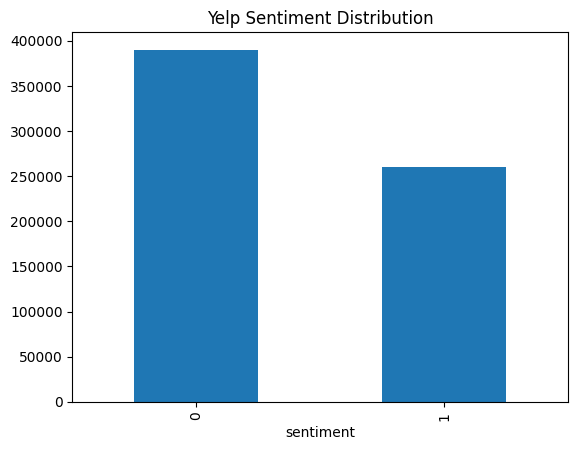

In [3]:
print(df_train['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())

import matplotlib.pyplot as plt
df_train['sentiment'].value_counts().plot(kind='bar', title="Yelp Sentiment Distribution")
plt.show()


In [4]:
import random

def simple_predict(text):
    if "good" in text or "great" in text or "excellent" in text:
        return 1
    elif "bad" in text or "terrible" in text or "awful" in text:
        return 0
    else:
        return random.choice([0, 1])

sample_texts = df_test['text'].head(20)
y_true = df_test['sentiment'].head(20).tolist()
y_pred = [simple_predict(t) for t in sample_texts]


In [5]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)


Accuracy: 0.4


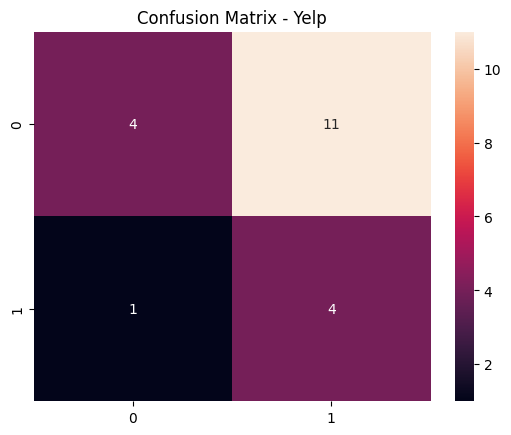

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - Yelp")
plt.show()


In [7]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))


Precision: 0.26666666666666666
Recall: 0.8
F1-Score: 0.4

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.27      0.40        15
    positive       0.27      0.80      0.40         5

    accuracy                           0.40        20
   macro avg       0.53      0.53      0.40        20
weighted avg       0.67      0.40      0.40        20



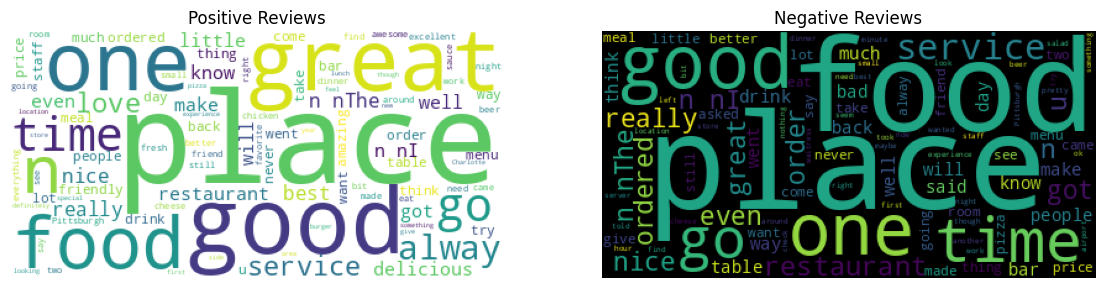

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pos_text = " ".join(df_train[df_train['sentiment'] == 1]['text'].head(5000))
neg_text = " ".join(df_train[df_train['sentiment'] == 0]['text'].head(5000))

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

wc_pos = WordCloud(background_color='white', max_words=100).generate(pos_text)
wc_neg = WordCloud(background_color='black', max_words=100).generate(neg_text)

axs[0].imshow(wc_pos)
axs[0].axis('off')
axs[0].set_title("Positive Reviews")

axs[1].imshow(wc_neg)
axs[1].axis('off')
axs[1].set_title("Negative Reviews")

plt.show()

In [9]:
from collections import Counter

classes = [0, 1]
class_top_words = {}

for c in classes:
    texts = " ".join(df_train[df_train['sentiment'] == c]['text'].head(10000))
    words = texts.split()
    counter = Counter(words)
    top_words = set([w for w, _ in counter.most_common(200)])
    class_top_words[c] = top_words
    print(f"Class {c} top words extracted")

Class 0 top words extracted
Class 1 top words extracted


In [10]:
common_words = class_top_words[0].intersection(class_top_words[1])

class_unique_words = {
    0: class_top_words[0] - common_words,
    1: class_top_words[1] - common_words
}

print("Unique words ready.")

Unique words ready.


In [11]:
def predict_simple(text):
    words = text.split()
    counts = {0:0, 1:0}
    for c in [0,1]:
        for w in words:
            if w in class_unique_words[c]:
                counts[c] += 1
    if counts[0] > counts[1]:
        return 0
    elif counts[1] > counts[0]:
        return 1
    else:
        return 1

df_test['pred'] = df_test['text'].apply(predict_simple)

accuracy = (df_test['pred'] == df_test['sentiment']).mean()
print("Accuracy:", accuracy)


Accuracy: 0.6255


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


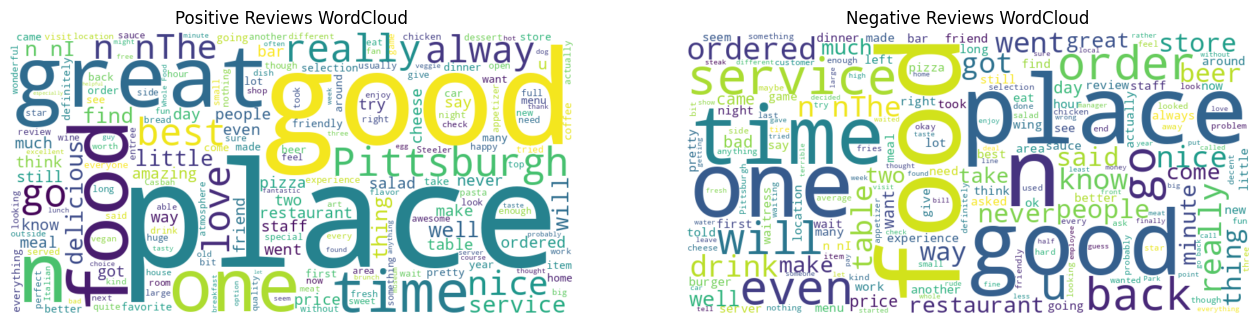

In [2]:
!pip install datasets wordcloud --quiet

from datasets import load_dataset
import pandas as pd

dataset = load_dataset("yelp_review_full")

df_train = pd.DataFrame(dataset['train'])
df_test  = pd.DataFrame(dataset['test'])

def label_map(star):
    if star in [3, 4, 5]:
        return 1
    else:
        return 0

df_train['sentiment'] = df_train['label'].apply(label_map)
df_test['sentiment']  = df_test['label'].apply(label_map)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_texts = " ".join(df_train[df_train['sentiment']==1]['text'].head(500).tolist())
negative_texts = " ".join(df_train[df_train['sentiment']==0]['text'].head(500).tolist())

wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")
plt.show()


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

X_train = tfidf.fit_transform(df_train['text'])
X_test  = tfidf.transform(df_test['text'])

y_train = df_train['sentiment']
y_test  = df_test['sentiment']


In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [5]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print(classification_report(y_test, y_pred))


Accuracy: 0.86224
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     30000
           1       0.83      0.82      0.83     20000

    accuracy                           0.86     50000
   macro avg       0.86      0.85      0.86     50000
weighted avg       0.86      0.86      0.86     50000



In [6]:
for i in range(5):
    print("Text:", df_test['text'].iloc[i])
    print("Actual:", y_test.iloc[i], "Predicted:", y_pred[i])
    print("-"*50)


Text: I got 'new' tires from them and within two weeks got a flat. I took my car to a local mechanic to see if i could get the hole patched, but they said the reason I had a flat was because the previous patch had blown - WAIT, WHAT? I just got the tire and never needed to have it patched? This was supposed to be a new tire. \nI took the tire over to Flynn's and they told me that someone punctured my tire, then tried to patch it. So there are resentful tire slashers? I find that very unlikely. After arguing with the guy and telling him that his logic was far fetched he said he'd give me a new tire \"this time\". \nI will never go back to Flynn's b/c of the way this guy treated me and the simple fact that they gave me a used tire!
Actual: 0 Predicted: 0
--------------------------------------------------
Text: Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, n

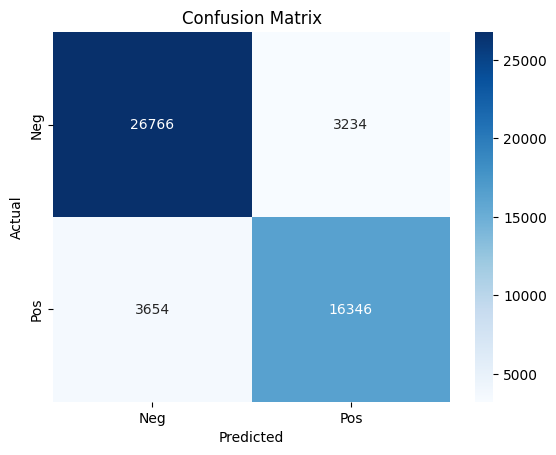

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [8]:
import joblib

joblib.dump(model, "yelp_sentiment_model.pkl")

joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']